# Task description

Take your favorite novel (or simply the one available in an electronic version) and look for:
1. chracter mentions pro page,
2. top 20 keywords,
3. sentiment of every chapter and/or page,
4. graph of co-occurences (defined as mentions on the same page).

Visualize the results.

---

# Solution

We will be using `ebooklib` library for manipulating epub files, `bs4` for parsing HTML data, `re` for filtering it further, `spaCy` for text analysis and `networkx` combined with `matplotlib` for data visualization.

In [1]:
# Handling epub files.
import ebooklib
from ebooklib import epub
# Parsing HTML data.
from bs4 import BeautifulSoup
# For parsing the text data.
import re
# Text analysis.
import numpy as np
import string
import collections
import itertools
import spacy
import textblob
# Graph construction and visualization.
import networkx as nx
import matplotlib.pyplot as plt

We will also tune global plotting settings, so the figures appear bigger.

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [20, 12]

## Reading the `epub` file.

In [3]:
PATH = r'./data/the-name-of-the-rose.epub'
book_epub = epub.read_epub(PATH)

After reading the file we will extract its contents as a generator of HTML documents.

In [4]:
html_docs = list(book_epub.get_items_of_type(ebooklib.ITEM_DOCUMENT))

## Parsing HTML data
For extracting text data from the HTML documents we will just single method from `bs4` library.

In [5]:
sections = []
for html_doc in html_docs:
    sections.append(BeautifulSoup(html_doc.get_body_content()).get_text())

Anyone who read the book knows that chapter starts with a time of day and a short note (most time ambiguous) about what's going to happen, e.g.

In [6]:
print(sections[10][:300] + ' [...]')  # Only first 300 characters.


Prime

In which the foot of the abbey is reached, and William demonstrates his great acumen.

 
It was a beautiful morning at the end of November. During the night it had snowed, but only a little, and the earth was covered with a cool blanket no more than three fingers high. In the darkness, immed [...]


We can use that information to extract only those sections which are proper chapters (leaving pages as info about author or prologue out of equation).

For that we will use a relatively simple regex.

In [7]:
chapters = [section for section in sections if re.match(r'^\n.+\n\n.+\n\n', section)]

In [8]:
len(chapters)

47

As we can can see we are left with only 47 chapters.

## Changing chapters into pages.

**Splitting the text into pages is something concerning specific edition and not the book it self. As long as the book does not contain ilustrations, then it can be split arbitrarly (with respect to all typographic rules). In era of digital ebook readers concept of page is even more outdated, because users can freqently change the font size, which shifts the amount of text on single page.**

Nevertheless, some of the exercises ask for pages explicitely, so we will define an arbirary number of characters, which can fit into single page. Let us set it to 2300 (checked experimentaly, format B5, font size 11).

In [9]:
CHARS_PER_PAGE = 2300

In [10]:
pages = []
for chapter in chapters:
    tmp = chapter
    while tmp:
        pages.append(tmp[:CHARS_PER_PAGE])
        tmp = tmp[CHARS_PER_PAGE:]

## Character mentions per chapter

To check how many character mentions are in each chapter, we will define a list of characters (which, fortunately, is relatively short - after all action takes place in a monstery).

In [11]:
CHARACTERS = [
    'William',
    'Adso',
    'Abo',
    'Bernard Gui',
    'Jorge',
    'Malachi',
    'Severinus',
    'Adelmo',
    'Alinardo',
    'Aymaro',
    'Benno',
    'Berengar',
    'Jerome',
    'Michael',
    'Hugh',
    'Marsilis',
    'Michael',
    'Nicholas',
    'Pacificus',
    'Remigio',
    'Salvatore',
    'Ubertino',
    'Venantius',
    'Village girl'
]

Then we count mentions per chapter in simple loop:

In [12]:
mentions = []
for chapter in chapters:
    chapter_mentions = []
    for name in CHARACTERS:
        chapter_mentions.extend(re.findall(name, chapter))
    mentions.append(chapter_mentions)

and count them:

In [13]:
mentions_counts = [collections.Counter(characters) for characters in mentions]

For visualization we need to transform the data so that each name corresponds to a list of mentions (one per chapter).

In [14]:
mentions_per_character = {k: [] for k in CHARACTERS}
for mentions_count in mentions_counts:
    for character, count in mentions_per_character.items():
        count.append(mentions_count[character])

Then we calculate the cumulative sum

In [15]:
cumulative_mentions_per_character = {
    character: np.cumsum(mentions) for character, mentions in mentions_per_character.items()
}

and visualize the result

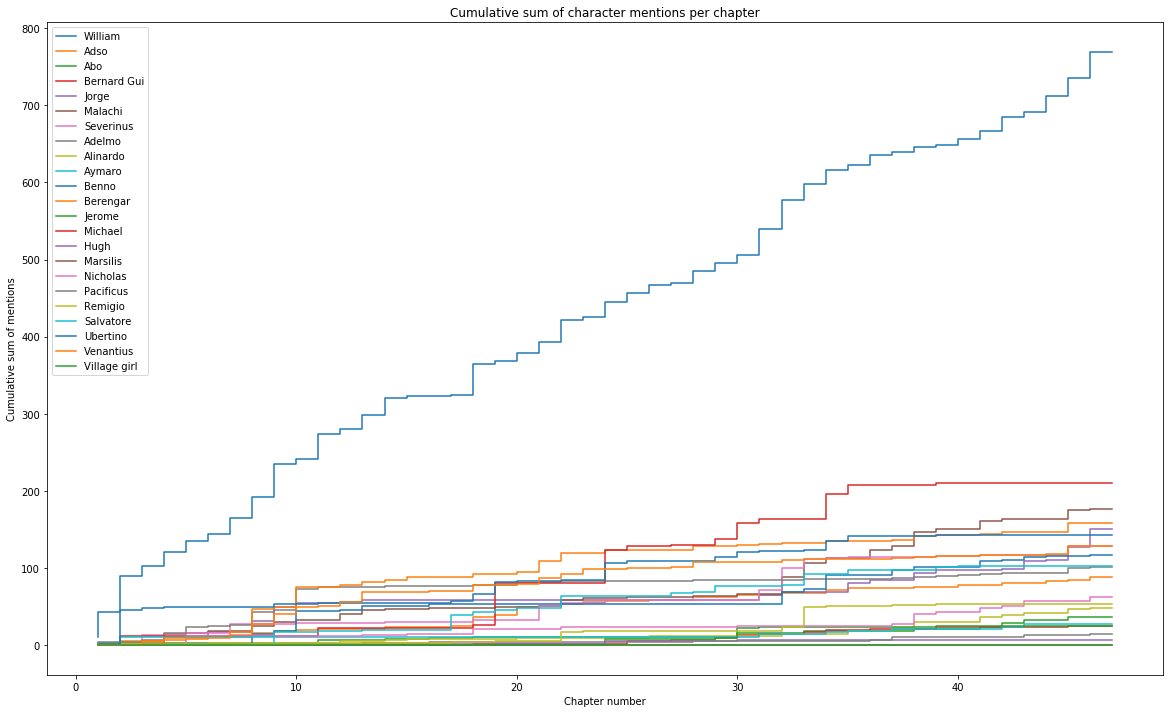

In [16]:
for character, counts in cumulative_mentions_per_character.items():
    plt.step(range(1, len(chapters) + 1), counts, label=character)
plt.legend()
plt.xlabel('Chapter number')
plt.ylabel('Cumulative sum of mentions')
plt.title('Cumulative sum of character mentions per chapter')
plt.show()

As we might have expected William is the one, who is mentioned the most. Adso, the second main character does not have that many mentions because most of the chapters are written from his perpective.

## Character mentions per page
We perform the same steps as before, but this time on each page.

We count the mentions

In [17]:
mentions_per_page = []
for page in pages:
    chapter_mentions = []
    for name in CHARACTERS:
        chapter_mentions.extend(re.findall(name, page))
    mentions_per_page.append(chapter_mentions)

In [18]:
mentions_per_page_counts = [collections.Counter(characters) for characters in mentions_per_page]

Modify the data

In [19]:
mentions_per_character_per_page = {k: [] for k in CHARACTERS}
for mentions_count in mentions_per_page_counts:
    for character, count in mentions_per_character_per_page.items():
        count.append(mentions_count[character])

In [20]:
cumulative_mentions_per_character_per_page = {
    character: np.cumsum(mentions) for character, mentions in mentions_per_character_per_page.items()
}

And visualize it

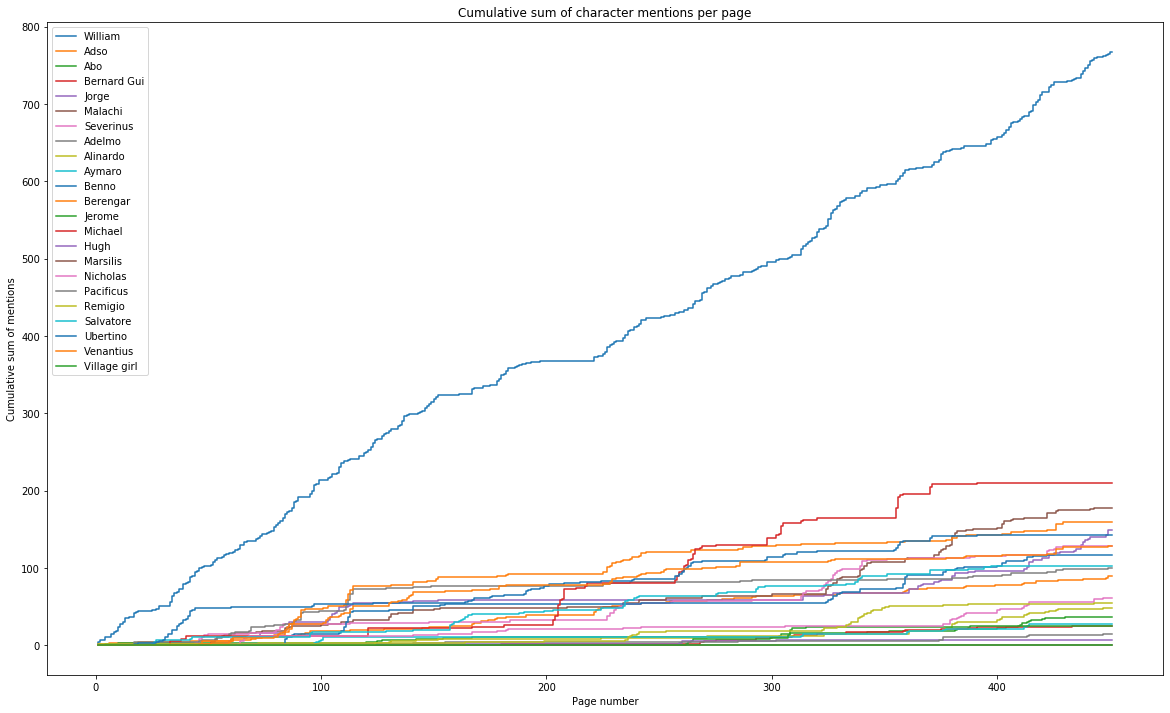

In [21]:
for character, counts in cumulative_mentions_per_character_per_page.items():
    plt.step(range(1, len(pages) + 1), counts, label=character)
plt.legend()
plt.xlabel('Page number')
plt.ylabel('Cumulative sum of mentions')
plt.title('Cumulative sum of character mentions per page')
plt.show()

This plot, obviously, is just the previous one (per chapter), but with higher resolution, so it's hard to draw any new conclusions.

## Analysis using `spaCy`
For analyzing the language we will use the `spaCy` library which will tag words (or even punctuation) according to their part of speech (POS tagging). 

First we have to load appropriate language model

In [22]:
nlp = spacy.load('en_core_web_sm')

Then we join chapters into single string and feed it to the `nlp` object (which will do the tagging)

In [23]:
full_text = '\n'.join([*chapters])
full_doc = nlp(full_text)

As keywords we will consider only nouns

In [24]:
keywords = [tag.text for tag in full_doc if tag.pos_ == 'NOUN']

We count them and extract 20 most common.

In [25]:
top20 = collections.Counter(keywords).most_common(21)[1:]

We split the data into words and counts to generate a beautiful histogram!

In [26]:
top_keywords = [word for word, count in top20]
top_counts = [count for word, count in top20]

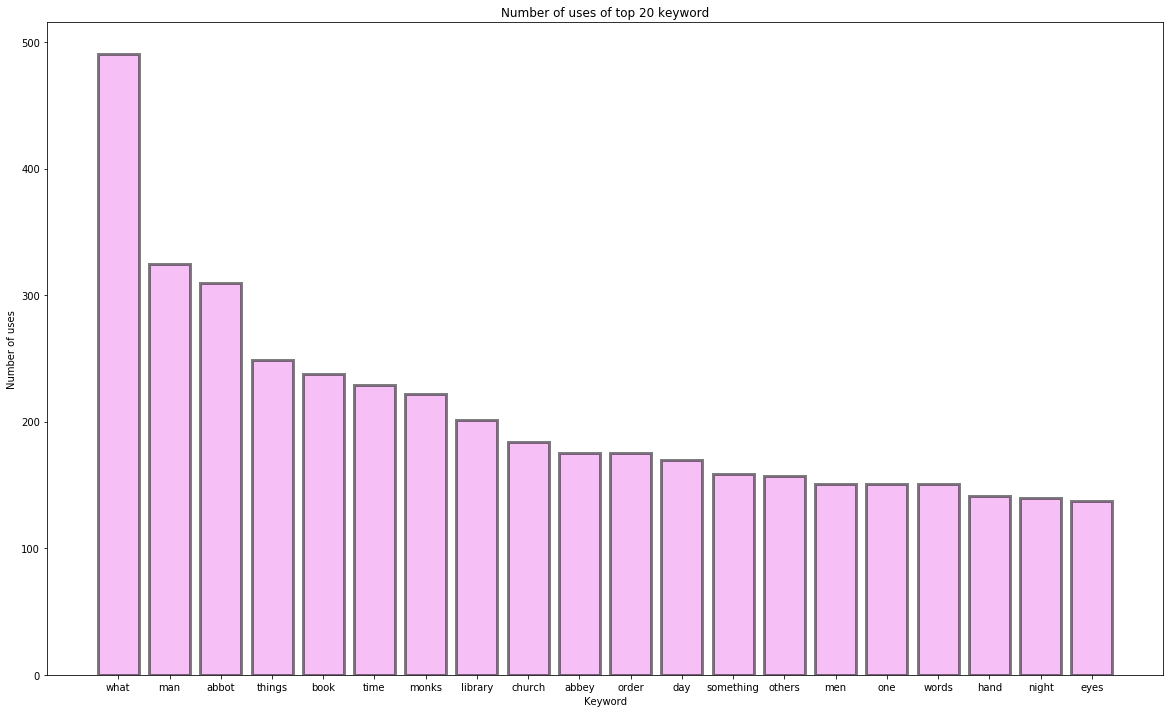

In [27]:
plt.bar(top_keywords, top_counts, alpha=0.5, linewidth=3, edgecolor='k', color='violet')
plt.xlabel('Keyword')
plt.ylabel('Number of uses')
plt.title('Number of uses of top 20 keyword')
plt.show()

For a well-read person those words will most probably point out to this exact book. *Abbot*, *book*, *monk*, *library* reflect the plot without any doubt.


## Co-occurences per chapter
Now we will generate a graph of co-occurences of characters per chapter. 

Characters are linked if the co-occur in the same same chapter. For visualization purposes we will consider only first three chapters.

In [28]:
graph_chapters = nx.Graph()
for chapter_mentions in mentions_counts[:3]:
    graph_chapters.add_edges_from(itertools.permutations(chapter_mentions.keys(), 2))

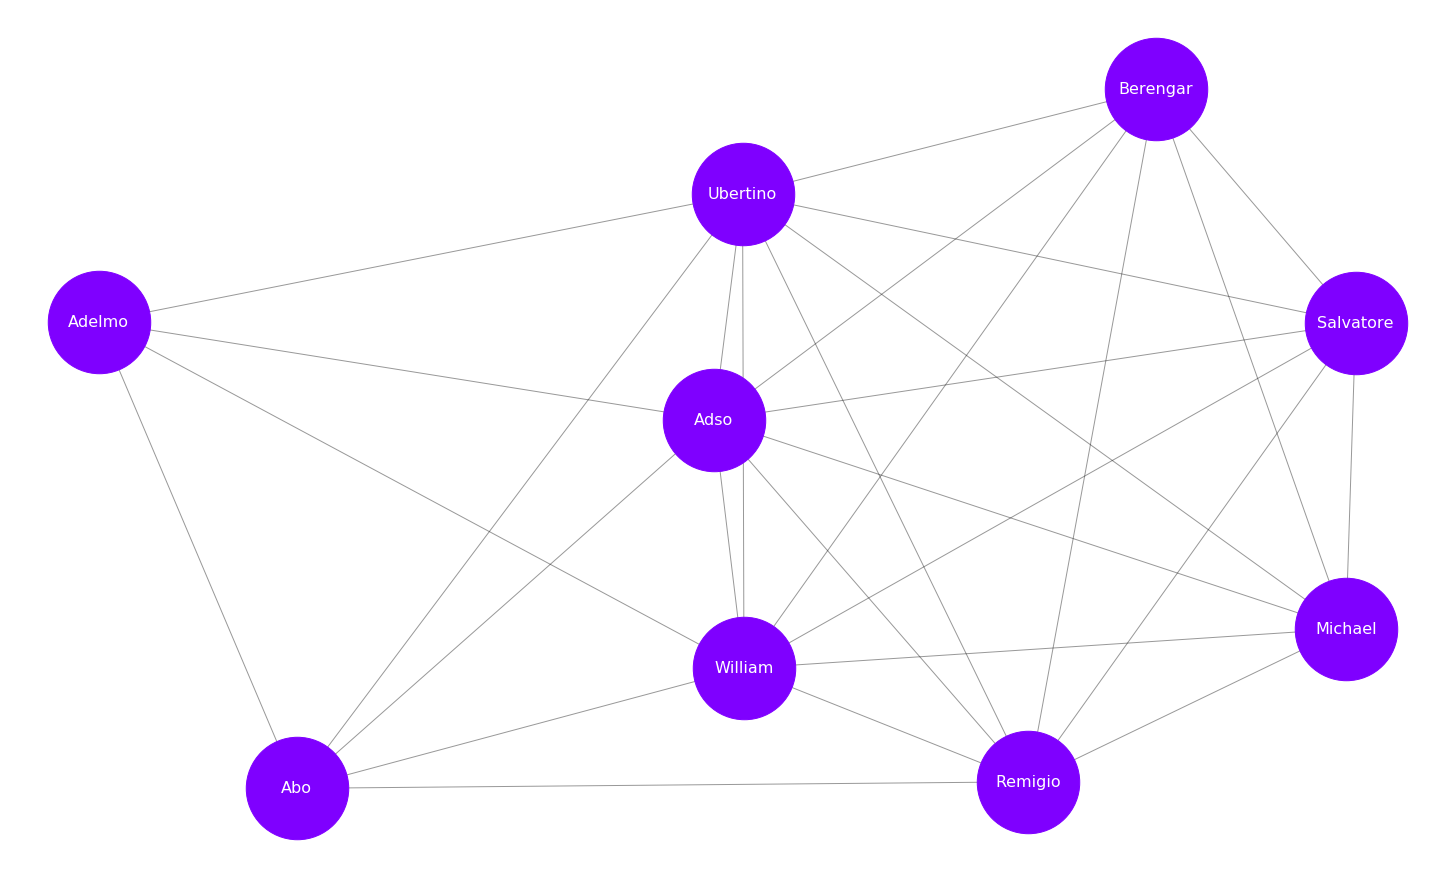

In [29]:
nx.draw(graph_chapters, 
        with_labels=True, 
        node_size=10500, 
        font_color='w', 
        font_size=16, 
        edge_color=(0, 0, 0, 0.4), 
        node_color='#7F00FF')

Main characters of the story: Adso and William are fully connected to other people (as we might have expected), but even without that the graph is very close to being complete, which reflects the closed environment of monastery, where each monk is supossed to know everyone else.

## Co-occurences per page
We performe the same analysis as previously, but on resolution of single page.

For readability we display co-occurences on only the first 30 pages.

In [30]:
graph_pages = nx.Graph()
for chapter_mentions in mentions_per_page_counts[:30]:
    graph_pages.add_edges_from(itertools.permutations(chapter_mentions.keys(), 2))

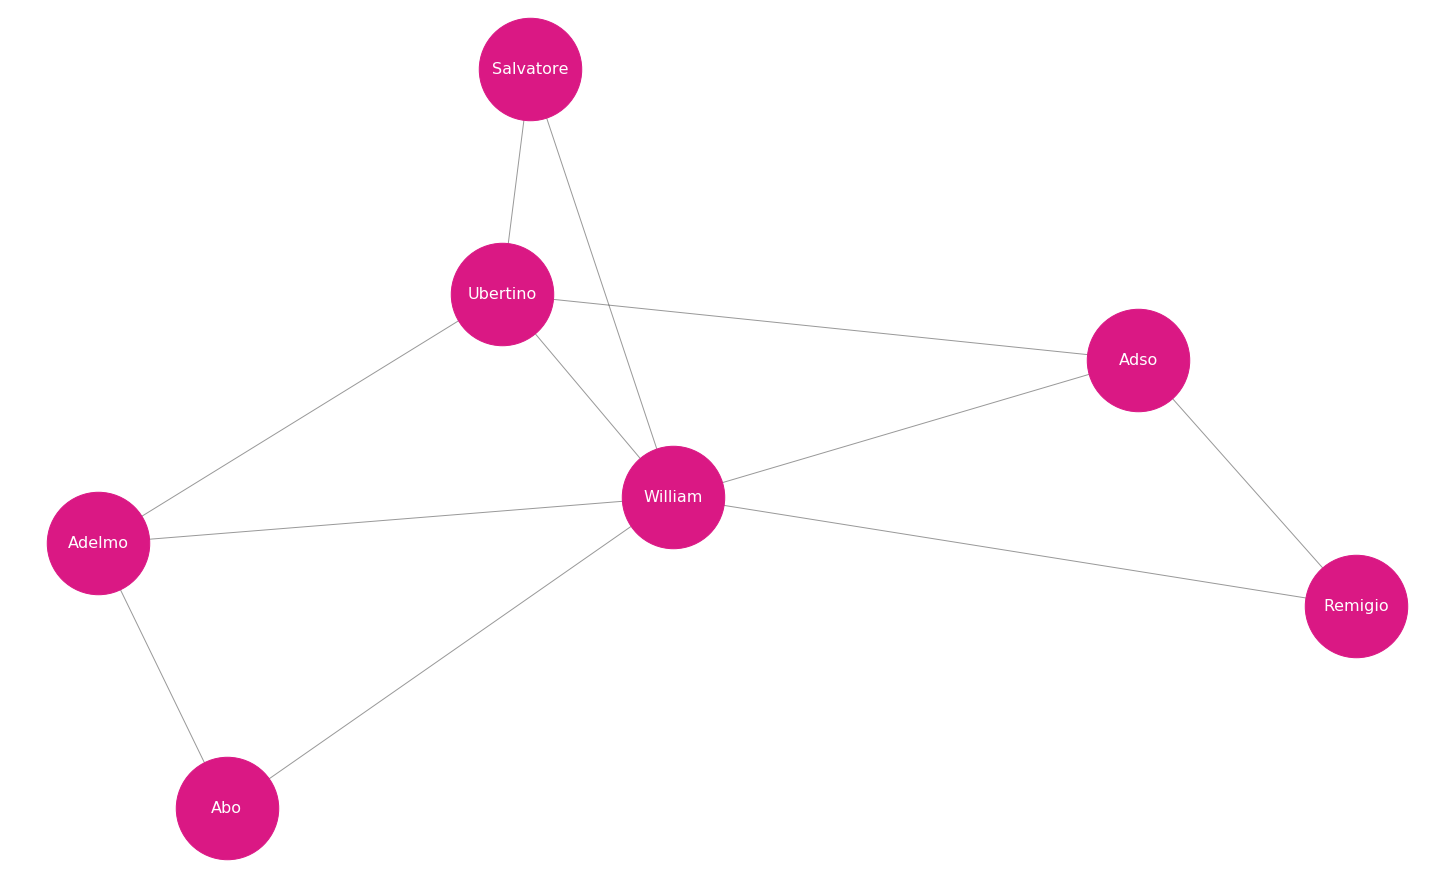

In [31]:
nx.draw(graph_pages, 
        with_labels=True, 
        node_size=10500, 
        font_color='w', 
        font_size=16, 
        edge_color=(0, 0, 0, 0.4), 
        node_color='#DA1884')

As previously William is connected to everyone else, but this time Adso (the narrator) *meets* only half of mentioned characters.

## Sentiment analysis
For sentiment analysis we will use the `tetblob` libary, which exposes a simple interface for accesing text polarity and subjectivity.

### Sentiment analysis per chapter

In [32]:
chapters_blobs = [textblob.TextBlob(chapter) for chapter in chapters]

In [33]:
chapters_polarity = []
chapters_subjectivity = []
for chapter in chapters_blobs:
    sentiment = chapter.sentiment
    chapters_polarity.append(sentiment.polarity)
    chapters_subjectivity.append(sentiment.subjectivity)

### Sentiment analysis per page

In [34]:
pages_blobs = [textblob.TextBlob(page) for page in pages]
pages_polarity = []
pages_subjectivity = []
for page in pages_blobs:
    sentiment = page.sentiment
    pages_polarity.append(sentiment.polarity)
    pages_subjectivity.append(sentiment.subjectivity)

### Visualization

Polarity per chapter

In [35]:
chapters_domain = range(1, len(chapters) + 1)
pages_domain = range(1, len(pages) + 1)

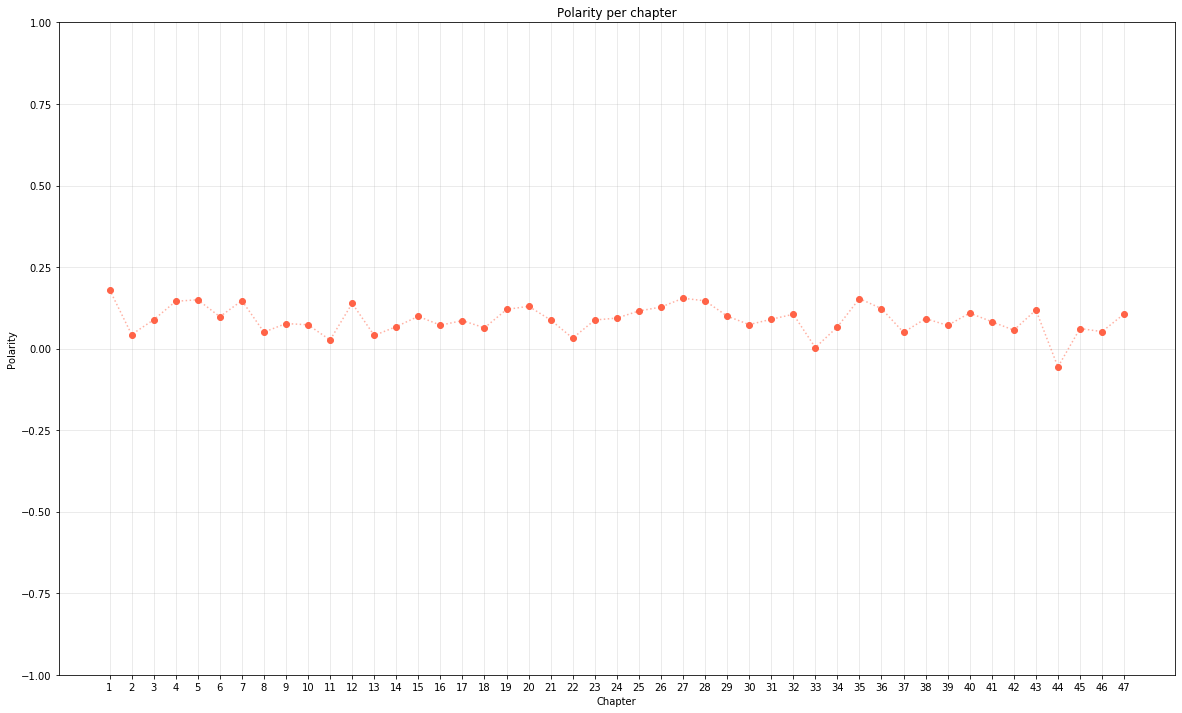

In [36]:
plt.plot(chapters_domain, chapters_polarity, 'o', color='tomato')
plt.plot(chapters_domain, chapters_polarity, ':', color='tomato', alpha=0.5)
plt.grid(alpha=0.3)
plt.xticks(chapters_domain)
plt.ylim([-1, 1])
plt.xlabel('Chapter')
plt.ylabel('Polarity')
plt.title('Polarity per chapter')
plt.show()

Most of the time sentiment analysis is used to examine polarity of social media, comments or thinks like that, but may perform poorely when used novel, especially when the language is relatively complex (as it is in Umberto Eco's book case). We can see that "The Name of the Rose" is very close to the average, but slighty positive (besides the fourth chapter from the end, where some bad thinks happen).

Polarity per page:

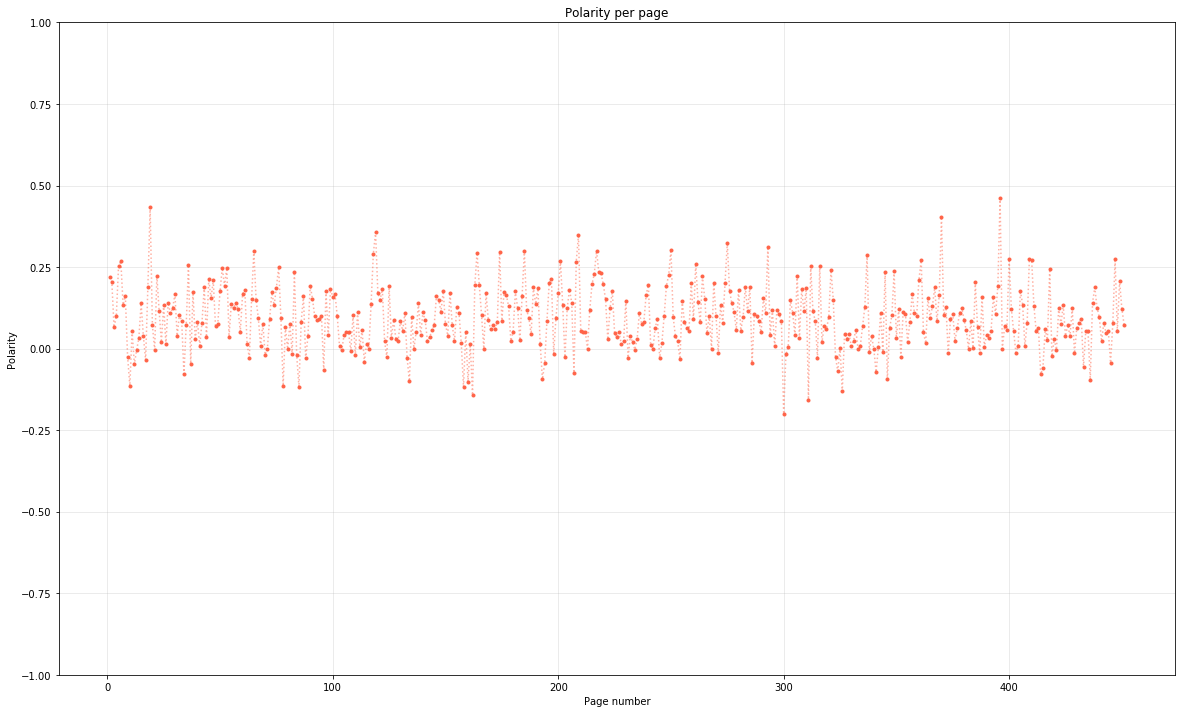

In [37]:
plt.plot(pages_domain, pages_polarity, '.', color='tomato')
plt.plot(pages_domain, pages_polarity, ':', color='tomato', alpha=0.5)
plt.grid(alpha=0.3)
plt.ylim([-1, 1])
plt.xlabel('Page number')
plt.ylabel('Polarity')
plt.title('Polarity per page')
plt.show()

Analyzing the polarity on a page level introduces higher variance, which is expected.


Subjectivity per chapter:

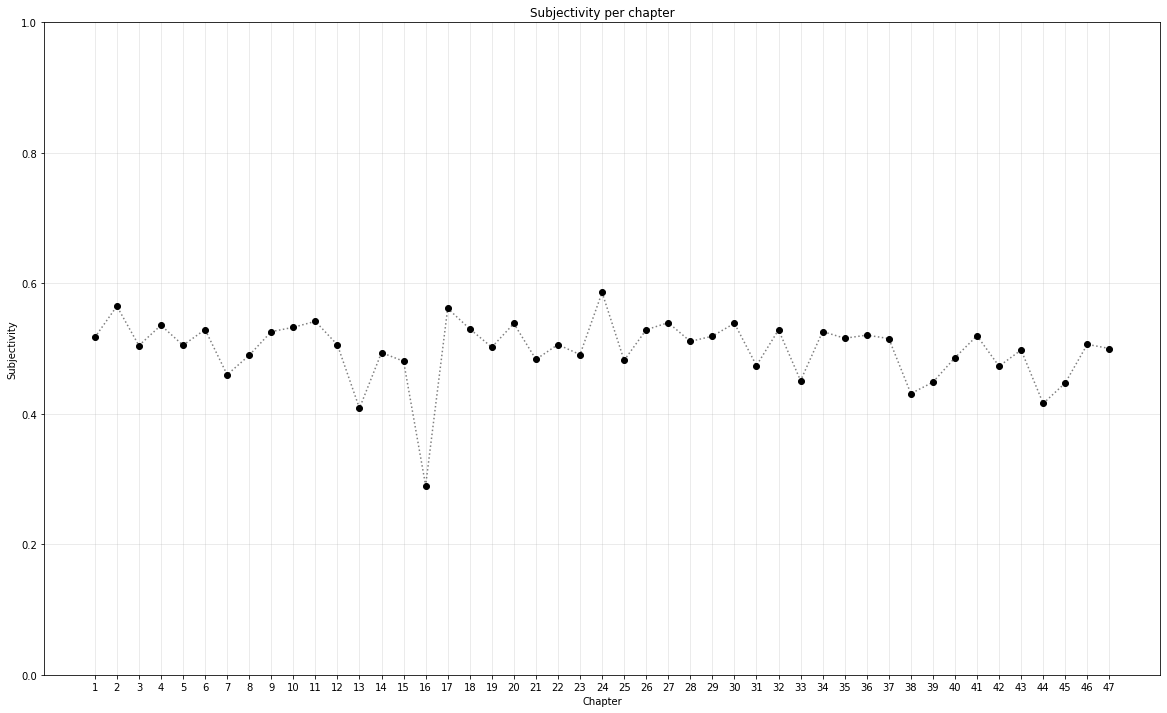

In [38]:
plt.plot(chapters_domain, chapters_subjectivity, 'o', color='k')
plt.plot(chapters_domain, chapters_subjectivity, ':', color='k', alpha=0.5)
plt.grid(alpha=0.3)
plt.xticks(chapters_domain)
plt.ylim([0, 1])
plt.xlabel('Chapter')
plt.ylabel('Subjectivity')
plt.title('Subjectivity per chapter')
plt.show()

As mentioned previously, analyzing sentiment on linguisticly difficult book, might provide questionable result. Again the book seems to be perfectly in the middle, it is neither fully objective nor subjective.

---

Subjectivity per page:

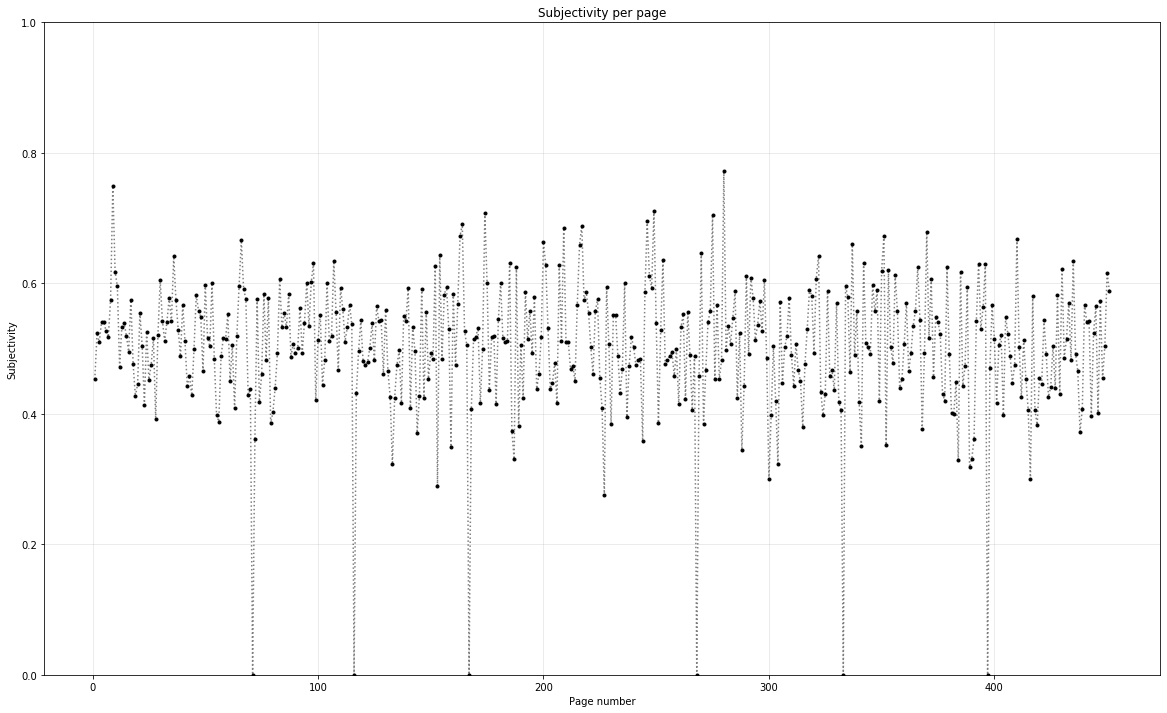

In [39]:
plt.plot(pages_domain, pages_subjectivity, '.', color='k')
plt.plot(pages_domain, pages_subjectivity, ':', color='k', alpha=0.5)
plt.grid(alpha=0.3)
plt.ylim([0, 1])
plt.xlabel('Page number')
plt.ylabel('Subjectivity')
plt.title('Subjectivity per page')
plt.show()

Analyzing the subjectivity on a page level introduces higher variance and even some observations which are said to be absolutely objective, but those might be last pages of given chapter, thus containing only dozen of words.